In [1]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import accuracy_score

import numpy as np
import matplotlib.pyplot as plt

from cv_svm import SVM_smooth

In [2]:
X, y = load_breast_cancer(return_X_y=True)
n = X.shape[0]
p = X.shape[1]
y[np.where(y == 0)] = -1

In [3]:
X = StandardScaler().fit_transform(X)
print(X.shape)

(569, 30)


In [4]:
clf = SVC(kernel='linear')
clf.fit(X, y)
sk_coef = clf.coef_/np.linalg.norm(clf.coef_)
print(clf.coef_)
print(clf.intercept_)

[[-0.32157975 -0.0963414  -0.29618472 -0.27044914  0.0145657   0.61925944
  -0.75749079 -0.90968508 -0.07847361  0.34800574 -0.84095245  0.30550603
  -0.23541953 -0.89135374 -0.35509455  0.39115374  0.37739417 -0.46041889
   0.10093298  0.88583541 -0.59013908 -0.97190388 -0.33349947 -0.71227359
  -0.42708268  0.1721726  -1.03818882 -0.09378355 -0.44679874 -0.85526809]]
[0.04438971]


In [5]:
y_pred = clf.predict(X)
accuracy_score(y, y_pred)

0.9876977152899824

In [6]:
clf = SVM_smooth(sigma=2e-35, lbd=1)
clf.fit(X, y, thresh=1e-3, n_iter=8000, eta=0.5/n, approx_cv=True, cv=True, log_iacv=True)
print(f"grad {np.linalg.norm(clf.nabla_fgd_(X, y, clf.weights_, clf.sigma_, clf.lbd_))}")
coef = clf.weights_/np.linalg.norm(clf.weights_)
print(f"diff {np.mean(np.abs(coef - sk_coef))} | pct {np.mean(np.abs(coef - sk_coef))/np.sum(np.abs(coef))}")

y_pred = clf.predict(X)
accuracy_score(y, y_pred)

IACV: 3.811821898125345e-06 | baseline: 0.0024778386848001988
IACV: 9.028679414768703e-06 | baseline: 0.002471319873095643
IACV: 1.6067393517005257e-05 | baseline: 0.0024648196583519247
IACV: 2.5108382033067755e-05 | baseline: 0.0024583381856246034
IACV: 3.622827716753818e-05 | baseline: 0.002451875601578655
IACV: 4.946253829984926e-05 | baseline: 0.0024454320545208557
IACV: 6.482942990260199e-05 | baseline: 0.002439007694432006
IACV: 8.233902917709202e-05 | baseline: 0.0024326026729988496
IACV: 0.00010199700045632198 | baseline: 0.002426217143645544
IACV: 0.00012380641419440508 | baseline: 0.0024198512615645216
IACV: 0.0001477688638260588 | baseline: 0.0024135051837465807
IACV: 0.0001738848368404433 | baseline: 0.002407179069010041
IACV: 0.00020215430413372815 | baseline: 0.0024008730780287623
IACV: 0.00023257663997355849 | baseline: 0.0023945873733588518
IACV: 0.0002651510003488511 | baseline: 0.002388322119463851
IACV: 0.00029987626476213336 | baseline: 0.002382077482738198
IACV: 0.

KeyboardInterrupt: 

In [ ]:
iacv_coef = normalize(clf.loo_iacv_, axis=1)
true_coef = normalize(clf.loo_true_, axis=1)
print(np.mean(np.linalg.norm(iacv_coef - true_coef, 2, axis=1)))
print(np.mean(np.linalg.norm(coef - true_coef, 2, axis=1)))

In [ ]:
print(iacv_coef)
print(true_coef)

In [ ]:
print(np.std(clf.loo_iacv_))
print(np.std(clf.loo_true_))

In [ ]:
print(np.mean(clf.loo_iacv_, axis=0))
print(np.mean(clf.loo_true_, axis=0))

In [ ]:
plt.hist(np.mean(clf.loo_iacv_, axis=0), alpha=0.5, bins=30, label="IACV")
plt.hist(np.mean(clf.loo_true_, axis=0), alpha=0.5, bins=30, label="true")
plt.legend()

In [ ]:
clf.loo_iacv_

In [ ]:
clf.loo_true_

In [ ]:
iacv_mean = np.mean(clf.loo_iacv_, axis=0)
coef = iacv_mean/np.linalg.norm(iacv_mean)
print(f"diff {np.mean(np.abs(coef - sk_coef))} | pct {np.mean(np.abs(coef - sk_coef))/np.sum(np.abs(coef))}")

In [ ]:
true_cv_mean = np.mean(clf.loo_true_, axis=0)
coef = true_cv_mean/np.linalg.norm(true_cv_mean)
print(f"diff {np.mean(np.abs(coef - sk_coef))} | pct {np.mean(np.abs(coef - sk_coef))/np.sum(np.abs(coef))}")

In [ ]:
coef = clf.weights_/np.linalg.norm(clf.weights_)
nbin = 100
plt.hist(coef, bins=nbin, label="FGD", alpha=0.3)
plt.hist(sk_coef.flatten(), bins=nbin, label="sklearn", alpha=0.3)
plt.legend()
plt.show()

In [14]:
# test different sigma values
import time
#sigmas = [2e-30, 2e-25, 2e-15, 2e-10, 2e-5, 2e-1]
sigmas = [2e-15, 2e-10, 2e-5, 2e-3, 2e-1, 5e-1, 7e-1, 8e-1, 1, 1.25, 1.5, 2, 2.5, 5]
scores = []

start = time.time()
for s in sigmas:
    if s == 0:
        continue
    clf = SVM_smooth(sigma=s, lbd=1e-10)
    #clf.fit(X, y, thresh=5e-3, n_iter=1000, eta=0.5 * s, cv=False, approx_cv=True, log_iacv=False, log_iter=True)
    print(f"running experiment for sigma = {s}")
    clf.fit(X, y, thresh=1e-3, n_iter=2500, eta=0.5/n, approx_cv=True, cv=True, log_iacv=False, log_iter=False)
    y_pred = clf.predict(X)
    score = accuracy_score(y, y_pred)

    coef = clf.weights_/np.linalg.norm(clf.weights_)

    #print(clf.weights_)
    print(f"\tsigma {s} | score {score} | grad {np.linalg.norm(clf.nabla_fgd_(X, y, clf.weights_, clf.sigma_, clf.lbd_))} | sklearn diff {np.mean(np.abs(coef- sk_coef))}")
    print(f"\tIACV: {np.mean(np.linalg.norm(clf.loo_iacv_ - clf.loo_true_, 2, axis=1))} | baseline: {np.mean(np.linalg.norm(clf.weights_ - clf.loo_true_, 2, axis=1))}" )
    scores.append([np.mean(np.linalg.norm(clf.loo_iacv_ - clf.loo_true_, 2, axis=1)), np.mean(np.linalg.norm(clf.weights_ - clf.loo_true_, 2, axis=1))])

end = time.time()
print(end - start)

running experiment for sigma = 2e-15
	sigma 2e-15 | score 0.9701230228471002 | grad 0.1317288866614811 | sklearn diff 0.10986756025474256
	IACV: 0.013989453203976154 | baseline: 0.004962279792076099
running experiment for sigma = 2e-10
	sigma 2e-10 | score 0.9701230228471002 | grad 0.1317288866614811 | sklearn diff 0.10986756025473787
	IACV: 0.01398945227265358 | baseline: 0.004962279792075701
running experiment for sigma = 2e-05
	sigma 2e-05 | score 0.9701230228471002 | grad 0.13172917585980934 | sklearn diff 0.10986753675300025
	IACV: 0.009550102055072784 | baseline: 0.004962286831599039
running experiment for sigma = 0.002
	sigma 0.002 | score 0.9701230228471002 | grad 0.13262090717831454 | sklearn diff 0.10987422223279326
	IACV: 0.009169481694698334 | baseline: 0.004963060996883863
running experiment for sigma = 0.2
	sigma 0.2 | score 0.9701230228471002 | grad 0.13661403366970407 | sklearn diff 0.11148062303261001
	IACV: 0.008397694677114487 | baseline: 0.005014377188963046
running

In [15]:
print(scores)
scores = np.asarray(scores)

[[0.013989453, 0.004962279792076099], [0.013989452, 0.004962279792075701], [0.009550102, 0.004962286831599039], [0.009169482, 0.004963060996883863], [0.008397695, 0.005014377188963046], [0.0074897744, 0.0050624456282686225], [0.0069228485, 0.005110340180647856], [0.00666271, 0.00513809455731359], [0.006195587, 0.005199032837371556], [0.0057027387, 0.005281699660433045], [0.005293012, 0.00536773713223013], [0.0046573603, 0.005540282414448014], [0.0041884463, 0.005705821427527087], [0.0029348105, 0.00637800225562779]]


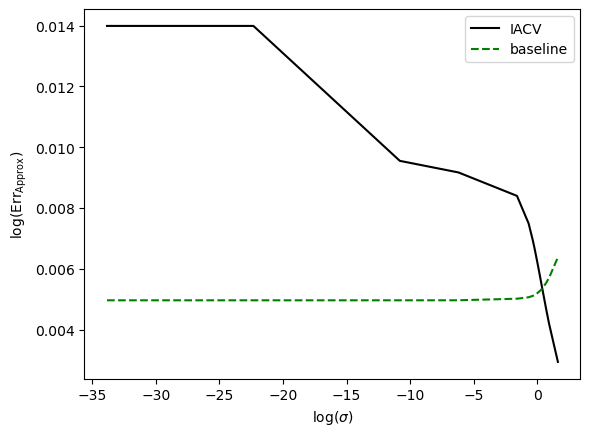

In [20]:
fig, ax = plt.subplots()
ax.plot(np.log(sigmas), scores[:, 0], label="IACV", c='black')
ax.plot(np.log(sigmas), scores[:, 1], label="baseline", c='green', linestyle="--")
ax.set_xlabel("$\log(\sigma)$")
ax.set_ylabel("$\log(\\text{Err}_\\text{Approx})$")
ax.legend()
plt.show()

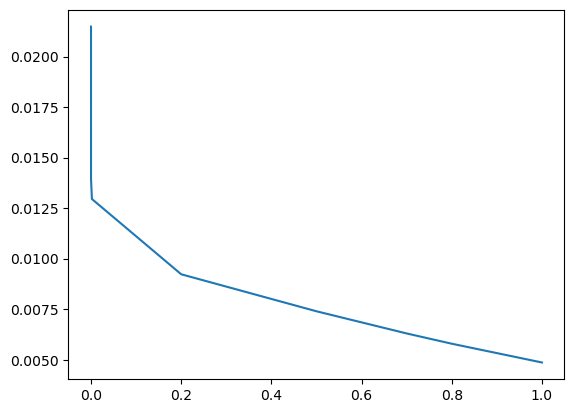

In [10]:
fig, ax = plt.subplots()
ax.plot(sigmas, scores[:, 0] - scores[:, 1])
plt.show()